In [152]:
from sklearn.datasets import load_boston
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
import pandas_profiling

Вы получили основные навыки обработки данных, теперь пора испытать их на практике. Сейчас вам предстоит заняться задачей классификации.

Представлен датасет центра приюта животных, и вашей задачей будет обучить модель таким образом, чтобы  по определенным признакам была возможность максимально уверенно предсказать метки 'Adoption' и 'Transfer' (столбец “outcome_type”).

Здесь вы вольны делать что угодно. Я хочу видеть от вас:
1. Проверка наличия/обработка пропусков
2. Проверьте взаимосвязи между признаками
3. Попробуйте создать свои признаки
4. Удалите лишние
5. Обратите внимание на текстовые столбцы. Подумайте, что можно извлечь полезного оттуда
6. Использование профайлера вам поможет.
7. Не забывайте, что у вас есть PCA (Метод главных компонент). Он может пригодиться.

Вспомните о всем, что я говорил на предыдущих занятиях. Не все будет пригодится, но в жизни вам никто не будет говорить, что использовать :)

Хорошим классификатором для этой задачи будет "Случайный лес" (https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html)

Понимать суть работы "леса" не обязательно на данном этапе, но качество предсказаний будет выше, чем с линейным классификатором. (если желаете, вот гайд https://adataanalyst.com/scikit-learn/linear-classification-method/)

Желаю успеха :)

In [153]:
data = pd.read_csv('aac_shelter_outcomes.csv')
data.head()

,age_upon_outcome,animal_id,animal_type,breed,color,date_of_birth,datetime,monthyear,name,outcome_subtype,outcome_type,sex_upon_outcome
0,2 weeks,A684346,Cat,Domestic Shorthair Mix,Orange Tabby,2014-07-07T00:00:00,2014-07-22T16:04:00,2014-07-22T16:04:00,NaN,Partner,Transfer,Intact Male
1,1 year,A666430,Dog,Beagle Mix,White/Brown,2012-11-06T00:00:00,2013-11-07T11:47:00,2013-11-07T11:47:00,Lucy,Partner,Transfer,Spayed Female
2,1 year,A675708,Dog,Pit Bull,Blue/White,2013-03-31T00:00:00,2014-06-03T14:20:00,2014-06-03T14:20:00,*Johnny,NaN,Adoption,Neutered Male
3,9 years,A680386,Dog,Miniature Schnauzer Mix,White,2005-06-02T00:00:00,2014-06-15T15:50:00,2014-06-15T15:50:00,Monday,Partner,Transfer,Neutered Male
4,5 months,A683115,Other,Bat Mix,Brown,2014-01-07T00:00:00,2014-07-07T14:04:00,2014-07-07T14:04:00,NaN,Rabies Risk,Euthanasia,Unknown


In [154]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 78256 entries, 0 to 78255
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   age_upon_outcome  78248 non-null  object
 1   animal_id         78256 non-null  object
 2   animal_type       78256 non-null  object
 3   breed             78256 non-null  object
 4   color             78256 non-null  object
 5   date_of_birth     78256 non-null  object
 6   datetime          78256 non-null  object
 7   monthyear         78256 non-null  object
 8   name              54370 non-null  object
 9   outcome_subtype   35963 non-null  object
 10  outcome_type      78244 non-null  object
 11  sex_upon_outcome  78254 non-null  object
dtypes: object(12)
memory usage: 7.2+ MB


In [155]:
# Просмотрим основные статистические данные
data.describe().T

,count,unique,top,freq
age_upon_outcome,78248,46,1 year,14355
animal_id,78256,70855,A718223,11
animal_type,78256,5,Dog,44242
breed,78256,2128,Domestic Shorthair Mix,23335
color,78256,525,Black/White,8153
date_of_birth,78256,5869,2014-05-05T00:00:00,112
datetime,78256,64361,2016-04-18T00:00:00,39
monthyear,78256,64361,2016-04-18T00:00:00,39
name,54370,14574,Bella,344
outcome_subtype,35963,19,Partner,19660


In [156]:
data.isnull().any()

age_upon_outcome     True
animal_id           False
animal_type         False
breed               False
color               False
date_of_birth       False
datetime            False
monthyear           False
name                 True
outcome_subtype      True
outcome_type         True
sex_upon_outcome     True
dtype: bool

In [157]:
# Посмотрим пропуски
data.isna().sum()

age_upon_outcome        8
animal_id               0
animal_type             0
breed                   0
color                   0
date_of_birth           0
datetime                0
monthyear               0
name                23886
outcome_subtype     42293
outcome_type           12
sex_upon_outcome        2
dtype: int64

### Предварительные выводы по пропускам:
1. 8 записей из 78256 по 'age_upon_outcome' - думаю можно убрать, т.к. всего 8 записей 
2. 23886 животных (~1/3) в приюте - безымянные. С точки зрения жизни возможно -> стоит рассмотреть выделение в отдельную категорию. Проанализируем далее, что делать с остальными записями
3. Подтип "выпуска из приюта" часто неопределен.
4. 12 записей из 78256 не задан тип выпуска из приюта (а это целевой признак). Так как всего 12 - думаю можем убрать 
5. 2 пустые записи 'sex_upon_outcome' - думаю можем убрать 

In [158]:
# Пункт №1, №4 и №5 - убираем не нужные нам строки 
# data[data['age_upon_outcome'].isna() == 1]
data = data.loc[~((data['age_upon_outcome'].isna() == 1) | (data['outcome_type'].isna() == 1) | (data['sex_upon_outcome'].isna() == 1))]
data.shape

(78237, 12)

In [159]:
# Пункт №2
# Мы имеем количество уникальных имен  - 14574
# популярные имена:
print("Популярные имена: \n")
print(data['name'].value_counts().head())

# редкие имена:
print("\n\nРедкие имена: \n")
print(data['name'].value_counts().tail())

Популярные имена: 

Bella       344
Max         319
Luna        239
Rocky       236
Princess    235
Name: name, dtype: int64


Редкие имена: 

Asad       1
Tybalt     1
* Henry    1
*Mundy     1
Borrego    1
Name: name, dtype: int64


In [160]:
# Посмотрим, сколько имен встречаются до 50 раз
for i in range(1,51):
    data_1 = data[data['name'].map(data['name'].value_counts()) == i]
    name_amt = len(data_1) / i
    print(f'{i} раз - {name_amt}')
    
# Среди 14575 уникальных имен, 8276 имен встречаются 1 раз. Есть 5 имен, которые встречаются 49 раз

1 раз - 8276.0
2 раз - 2196.0
3 раз - 1039.0
4 раз - 650.0
5 раз - 446.0
6 раз - 304.0
7 раз - 267.0
8 раз - 193.0
9 раз - 163.0
10 раз - 120.0
11 раз - 109.0
12 раз - 67.0
13 раз - 64.0
14 раз - 63.0
15 раз - 52.0
16 раз - 41.0
17 раз - 41.0
18 раз - 31.0
19 раз - 31.0
20 раз - 30.0
21 раз - 26.0
22 раз - 14.0
23 раз - 27.0
24 раз - 17.0
25 раз - 14.0
26 раз - 21.0
27 раз - 17.0
28 раз - 19.0
29 раз - 12.0
30 раз - 8.0
31 раз - 8.0
32 раз - 12.0
33 раз - 15.0
34 раз - 10.0
35 раз - 10.0
36 раз - 8.0
37 раз - 6.0
38 раз - 5.0
39 раз - 6.0
40 раз - 3.0
41 раз - 6.0
42 раз - 7.0
43 раз - 4.0
44 раз - 3.0
45 раз - 8.0
46 раз - 1.0
47 раз - 4.0
48 раз - 4.0
49 раз - 5.0
50 раз - 0.0


In [161]:
# Распределим имена по категориям
# Будем считать имя редким, если оно встречается меньше 20 раз

n = 20

# Получим список редких имен
s = data['name'].value_counts() < 20
s = s[s == True]
#print(s.index)

#Получили список редких имен, теперь созданим новый столбец с заменными редкими именами

data.loc[data['name'].isin(s.index) , 'name_upd'] = 'Other_name'
data.loc[data['name'].isna(), 'name_upd'] = 'Unknown'
data.loc[data['name_upd'].isnull() , 'name_upd'] = data['name']

data['name_upd'].value_counts().head()
# len(data['name_upd'])

Other_name    35516
Unknown       23875
Bella           344
Max             319
Luna            239
Name: name_upd, dtype: int64

In [162]:
# Пункт №3
# Заменим Nan на 'Not defined'
data.loc[data['outcome_subtype'].isna(), 'outcome_subtype'] = 'Not defined'

### Время:
1. Время до выпуска ('age_upon_outcome') сейчас представлено в неудобном текстовом формате. 
2. Переведем в удобный числовой формат. Представим date_of_birth, monthyear и datetime в UNIX

In [163]:
# Пункт №1
# Посмотрим все уникальные значения в age_upon_outcome
data['age_upon_outcome'].unique()

array(['2 weeks', '1 year', '9 years', '5 months', '4 months', '3 years',
       '1 month', '3 months', '2 years', '2 months', '4 years', '8 years',
       '3 weeks', '8 months', '12 years', '7 years', '5 years', '6 years',
       '5 days', '10 months', '4 weeks', '10 years', '2 days', '6 months',
       '14 years', '11 months', '15 years', '7 months', '13 years',
       '11 years', '16 years', '9 months', '3 days', '6 days', '4 days',
       '5 weeks', '1 week', '1 day', '1 weeks', '0 years', '17 years',
       '20 years', '18 years', '19 years', '22 years', '25 years'],
      dtype=object)

In [164]:
# нужно распарсить строку после пробела (допустим до дней)
def age_parser(value):

    pos = value.find(' ') 
    
    if value[pos+1] == 'd':
        return int(value[0:pos])
    elif value[pos+1] == 'w':
        return int(value[0:pos]) * 7
    elif value[pos+1] == 'm':
        return int(value[0:pos]) * 30
    elif value[pos+1] == 'y':
        return int(value[0:pos]) * 365

# Добавим столбец с количество дней до выпуска из приюта
data['age_upon_outcome_period'] = data['age_upon_outcome'].apply(age_parser)
data['age_upon_outcome_period'].head()

0      14
1     365
2     365
3    3285
4     150
Name: age_upon_outcome_period, dtype: int64

In [165]:
# Пункт №2
import time
from datetime import date
from datetime import datetime

# Пусть будет 2015 год в качестве точки отсчета
d = date(2015, 1, 1)

unixtime_0 = time.mktime(d.timetuple()) 

def get_unix_time(value):
    dt = datetime.strptime(value, '%Y-%m-%dT%H:%M:%S')
    unixtime = time.mktime(dt.timetuple())
    return (unixtime - unixtime_0)

# Добавим колонки с UNIX временем
data['date_of_birth_unix'] = data['date_of_birth'].apply(get_unix_time)
data['datetime_unix'] = data['datetime'].apply(get_unix_time)
data['monthyear_unix'] = data['monthyear'].apply(get_unix_time)

data.head()
#data[['date_of_birth_unix', 'datetime_unix', 'monthyear_unix']].head(10)

,age_upon_outcome,animal_id,animal_type,breed,color,date_of_birth,datetime,monthyear,name,outcome_subtype,outcome_type,sex_upon_outcome,name_upd,age_upon_outcome_period,date_of_birth_unix,datetime_unix,monthyear_unix
0,2 weeks,A684346,Cat,Domestic Shorthair Mix,Orange Tabby,2014-07-07T00:00:00,2014-07-22T16:04:00,2014-07-22T16:04:00,NaN,Partner,Transfer,Intact Male,Unknown,14,-15379200.0,-14025360.0,-14025360.0
1,1 year,A666430,Dog,Beagle Mix,White/Brown,2012-11-06T00:00:00,2013-11-07T11:47:00,2013-11-07T11:47:00,Lucy,Partner,Transfer,Spayed Female,Lucy,365,-67910400.0,-36245580.0,-36245580.0
2,1 year,A675708,Dog,Pit Bull,Blue/White,2013-03-31T00:00:00,2014-06-03T14:20:00,2014-06-03T14:20:00,*Johnny,Not defined,Adoption,Neutered Male,*Johnny,365,-55382400.0,-18265200.0,-18265200.0
3,9 years,A680386,Dog,Miniature Schnauzer Mix,White,2005-06-02T00:00:00,2014-06-15T15:50:00,2014-06-15T15:50:00,Monday,Partner,Transfer,Neutered Male,Other_name,3285,-302400000.0,-17223000.0,-17223000.0
4,5 months,A683115,Other,Bat Mix,Brown,2014-01-07T00:00:00,2014-07-07T14:04:00,2014-07-07T14:04:00,NaN,Rabies Risk,Euthanasia,Unknown,Unknown,150,-31017600.0,-15328560.0,-15328560.0


In [166]:
# 'datetime_unix', 'monthyear_unix' дублируют друг друга
data[['date_of_birth_unix', 'datetime_unix', 'monthyear_unix']].corr()

,date_of_birth_unix,datetime_unix,monthyear_unix
date_of_birth_unix,1.000000,0.383547,0.383547
datetime_unix,0.383547,1.000000,1.000000
monthyear_unix,0.383547,1.000000,1.000000


In [167]:
# Удалим все не нужные столбцы, которые мы обработали
data.drop(['name', 'age_upon_outcome', 'date_of_birth', 'datetime', 'monthyear'], axis = 1, inplace = True)
data.head()

,animal_id,animal_type,breed,color,outcome_subtype,outcome_type,sex_upon_outcome,name_upd,age_upon_outcome_period,date_of_birth_unix,datetime_unix,monthyear_unix
0,A684346,Cat,Domestic Shorthair Mix,Orange Tabby,Partner,Transfer,Intact Male,Unknown,14,-15379200.0,-14025360.0,-14025360.0
1,A666430,Dog,Beagle Mix,White/Brown,Partner,Transfer,Spayed Female,Lucy,365,-67910400.0,-36245580.0,-36245580.0
2,A675708,Dog,Pit Bull,Blue/White,Not defined,Adoption,Neutered Male,*Johnny,365,-55382400.0,-18265200.0,-18265200.0
3,A680386,Dog,Miniature Schnauzer Mix,White,Partner,Transfer,Neutered Male,Other_name,3285,-302400000.0,-17223000.0,-17223000.0
4,A683115,Other,Bat Mix,Brown,Rabies Risk,Euthanasia,Unknown,Unknown,150,-31017600.0,-15328560.0,-15328560.0


### ANIMAL_ID
Идентификатор представлен буквой A и кодом. 

In [168]:
# Проверим, какой в коде animal_id первый символ
data['animal_id1'] = data['animal_id'].apply(lambda x: x[0])
data['animal_id1'].unique()
# только буква "А", тогда ее уберем

array(['A'], dtype=object)

In [169]:
# Уберем букву
data.drop(['animal_id1'], axis = 1, inplace = True)
data['animal_id'] = data['animal_id'].apply(lambda x: x[1:])

### ANIMAL_TYPE

In [170]:
# Мало уникальных значений
data['animal_type'].unique()

array(['Cat', 'Dog', 'Other', 'Bird', 'Livestock'], dtype=object)

In [171]:
# преобразуем колонку animal_type в one-hot encoding вектор
one_hot = pd.get_dummies(data['animal_type'])
# Удаляем колонку species
data = data.drop(['animal_type'],axis = 1)
# добавляем колонку one-hot к исходной таблице
data = data.join(one_hot)
data.head()

,animal_id,breed,color,outcome_subtype,outcome_type,sex_upon_outcome,name_upd,age_upon_outcome_period,date_of_birth_unix,datetime_unix,monthyear_unix,Bird,Cat,Dog,Livestock,Other
0,684346,Domestic Shorthair Mix,Orange Tabby,Partner,Transfer,Intact Male,Unknown,14,-15379200.0,-14025360.0,-14025360.0,0,1,0,0,0
1,666430,Beagle Mix,White/Brown,Partner,Transfer,Spayed Female,Lucy,365,-67910400.0,-36245580.0,-36245580.0,0,0,1,0,0
2,675708,Pit Bull,Blue/White,Not defined,Adoption,Neutered Male,*Johnny,365,-55382400.0,-18265200.0,-18265200.0,0,0,1,0,0
3,680386,Miniature Schnauzer Mix,White,Partner,Transfer,Neutered Male,Other_name,3285,-302400000.0,-17223000.0,-17223000.0,0,0,1,0,0
4,683115,Bat Mix,Brown,Rabies Risk,Euthanasia,Unknown,Unknown,150,-31017600.0,-15328560.0,-15328560.0,0,0,0,0,1


### Sex_upon_outcome

In [172]:
# Мало уникальных значений
data['sex_upon_outcome'].unique()

array(['Intact Male', 'Spayed Female', 'Neutered Male', 'Unknown',
       'Intact Female'], dtype=object)

In [173]:
# преобразуем колонку в one-hot encoding вектор
one_hot = pd.get_dummies(data['sex_upon_outcome'])
# Удаляем колонку species
data = data.drop(['sex_upon_outcome'],axis = 1)
# добавляем колонку one-hot к исходной таблице
data = data.join(one_hot)
data.head()

,animal_id,breed,color,outcome_subtype,outcome_type,name_upd,age_upon_outcome_period,date_of_birth_unix,datetime_unix,monthyear_unix,Bird,Cat,Dog,Livestock,Other,Intact Female,Intact Male,Neutered Male,Spayed Female,Unknown
0,684346,Domestic Shorthair Mix,Orange Tabby,Partner,Transfer,Unknown,14,-15379200.0,-14025360.0,-14025360.0,0,1,0,0,0,0,1,0,0,0
1,666430,Beagle Mix,White/Brown,Partner,Transfer,Lucy,365,-67910400.0,-36245580.0,-36245580.0,0,0,1,0,0,0,0,0,1,0
2,675708,Pit Bull,Blue/White,Not defined,Adoption,*Johnny,365,-55382400.0,-18265200.0,-18265200.0,0,0,1,0,0,0,0,1,0,0
3,680386,Miniature Schnauzer Mix,White,Partner,Transfer,Other_name,3285,-302400000.0,-17223000.0,-17223000.0,0,0,1,0,0,0,0,1,0,0
4,683115,Bat Mix,Brown,Rabies Risk,Euthanasia,Unknown,150,-31017600.0,-15328560.0,-15328560.0,0,0,0,0,1,0,0,0,0,1


### ДЕТАЛЬНЫЙ ОТЧЕТ

In [146]:
# используем отличную библиотеку для более глубокого анализа 
# много полезной инфы можно получить ничего не делая руками
data.profile_report()

### смотрим внимательно на Warnings профайлера, есть интересные моменты, на которые нужно обратить внимания 

### Color

In [174]:
# считаем "компоненты" цвета
data['color_cnt'] = data['color'].apply(lambda x: x.count('/'))
data['color_cnt'].value_counts()

1    40966
0    37271
Name: color_cnt, dtype: int64

In [175]:
# Цвет описывается, либо 1, либо 2 параметрами через "/"
# Разбиваем цвет

def define_color(value, order):
    
    if value['color_cnt'] == 0:
        return value['color']
    else:
        pos = value['color'].find('/')
        colors = [value['color'][0:pos], value['color'][pos+1:]]
        colors.sort()
        if order == 1:
            return colors[0]
        elif order == 2:
            return colors[1]    

# Добавим новые столбцы с цветами
data['color1'] = data.apply(define_color,order = 1, axis = 1)
data['color2'] = data.apply(define_color,order = 2, axis = 1) 
data.head()

,animal_id,breed,color,outcome_subtype,outcome_type,name_upd,age_upon_outcome_period,date_of_birth_unix,datetime_unix,monthyear_unix,...,Livestock,Other,Intact Female,Intact Male,Neutered Male,Spayed Female,Unknown,color_cnt,color1,color2
0,684346,Domestic Shorthair Mix,Orange Tabby,Partner,Transfer,Unknown,14,-15379200.0,-14025360.0,-14025360.0,...,0,0,0,1,0,0,0,0,Orange Tabby,Orange Tabby
1,666430,Beagle Mix,White/Brown,Partner,Transfer,Lucy,365,-67910400.0,-36245580.0,-36245580.0,...,0,0,0,0,0,1,0,1,Brown,White
2,675708,Pit Bull,Blue/White,Not defined,Adoption,*Johnny,365,-55382400.0,-18265200.0,-18265200.0,...,0,0,0,0,1,0,0,1,Blue,White
3,680386,Miniature Schnauzer Mix,White,Partner,Transfer,Other_name,3285,-302400000.0,-17223000.0,-17223000.0,...,0,0,0,0,1,0,0,0,White,White
4,683115,Bat Mix,Brown,Rabies Risk,Euthanasia,Unknown,150,-31017600.0,-15328560.0,-15328560.0,...,0,1,0,0,0,0,1,0,Brown,Brown


In [176]:
# Удаляем ненужную нам информацию
data.drop(['color', 'color_cnt'], axis = 1, inplace = True)
data.head()

,animal_id,breed,outcome_subtype,outcome_type,name_upd,age_upon_outcome_period,date_of_birth_unix,datetime_unix,monthyear_unix,Bird,...,Dog,Livestock,Other,Intact Female,Intact Male,Neutered Male,Spayed Female,Unknown,color1,color2
0,684346,Domestic Shorthair Mix,Partner,Transfer,Unknown,14,-15379200.0,-14025360.0,-14025360.0,0,...,0,0,0,0,1,0,0,0,Orange Tabby,Orange Tabby
1,666430,Beagle Mix,Partner,Transfer,Lucy,365,-67910400.0,-36245580.0,-36245580.0,0,...,1,0,0,0,0,0,1,0,Brown,White
2,675708,Pit Bull,Not defined,Adoption,*Johnny,365,-55382400.0,-18265200.0,-18265200.0,0,...,1,0,0,0,0,1,0,0,Blue,White
3,680386,Miniature Schnauzer Mix,Partner,Transfer,Other_name,3285,-302400000.0,-17223000.0,-17223000.0,0,...,1,0,0,0,0,1,0,0,White,White
4,683115,Bat Mix,Rabies Risk,Euthanasia,Unknown,150,-31017600.0,-15328560.0,-15328560.0,0,...,0,0,1,0,0,0,0,1,Brown,Brown


### Остальные категориальные признаки

In [177]:
# Остальные категории объемные, поэтому для остальных признаков пойдем через LABEL_ENCODER

from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

data['breed_le'] = le.fit_transform(data['breed'])
data['outcome_subtype_le'] = le.fit_transform(data['outcome_subtype'])
data['name_upd_le'] = le.fit_transform(data['name_upd'])
data['color1_le'] = le.fit_transform(data['color1'])
data['color2_le'] = le.fit_transform(data['color2'])

# сразу почистим от ненужного
data.drop(['color1', 'color2', 'name_upd', 'outcome_subtype', 'breed', 'monthyear_unix'], axis = 1, inplace = True)

data.head()

,animal_id,outcome_type,age_upon_outcome_period,date_of_birth_unix,datetime_unix,Bird,Cat,Dog,Livestock,Other,Intact Female,Intact Male,Neutered Male,Spayed Female,Unknown,breed_le,outcome_subtype_le,name_upd_le,color1_le,color2_le
0,684346,Transfer,14,-15379200.0,-14025360.0,0,1,0,0,0,0,1,0,0,0,937,13,409,39,38
1,666430,Transfer,365,-67910400.0,-36245580.0,0,0,1,0,0,0,0,0,1,0,255,13,270,15,55
2,675708,Adoption,365,-55382400.0,-18265200.0,0,0,1,0,0,0,0,1,0,0,1612,11,45,7,55
3,680386,Transfer,3285,-302400000.0,-17223000.0,0,0,1,0,0,0,0,1,0,0,1467,13,308,55,55
4,683115,Euthanasia,150,-31017600.0,-15328560.0,0,0,0,0,1,0,0,0,0,1,253,15,409,15,15


### Нормализуем данные 

In [178]:
from sklearn import preprocessing

y = data['outcome_type']
X = data.drop(['outcome_type'], axis = 1)

#Задаем максимум и минимум новой нормализованной выборки через feature_range
min_max_scaler = preprocessing.MinMaxScaler(feature_range = (-1,1))

# Запоминаем названия столбцов
headers = list(X.columns.values)

# Трансформируем регрессоры, масштабируя каждую переменную к указанному диапазону
# Получааем построчный numpy array
np_scaled = min_max_scaler.fit_transform(X)

# Преобразуем в DataFrame
X_norm = pd.DataFrame(np_scaled)

# Восстанавливаем названия столбцов
X_norm.columns = headers
X_norm.head()

,animal_id,age_upon_outcome_period,date_of_birth_unix,datetime_unix,Bird,Cat,Dog,Livestock,Other,Intact Female,Intact Male,Neutered Male,Spayed Female,Unknown,breed_le,outcome_subtype_le,name_upd_le,color1_le,color2_le
0,0.784905,-0.996932,0.733572,-0.628533,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,-0.118532,0.368421,0.938389,0.368421,0.333333
1,0.737756,-0.920000,0.605720,-0.953175,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,-0.760113,0.368421,0.279621,-0.473684,0.929825
2,0.762173,-0.920000,0.636211,-0.690478,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,0.516463,0.157895,-0.786730,-0.754386,0.929825
3,0.774484,-0.280000,0.035012,-0.675251,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,0.380056,0.368421,0.459716,0.929825,0.929825
4,0.781665,-0.967123,0.695510,-0.647573,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,1.0,-0.761994,0.578947,0.938389,-0.473684,-0.473684


### ДЕРЕВО РЕШЕНИЙ

In [179]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_norm, y, test_size=0.3)

In [180]:
from sklearn.ensemble import RandomForestClassifier

# создаем модель деревья решений
# выбираем 100 деревьев в качестве параметра
model=RandomForestClassifier(n_estimators = 100, n_jobs = 4)

# обучаем модель
model.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=4,
                       oob_score=False, random_state=None, verbose=0,
                       warm_start=False)

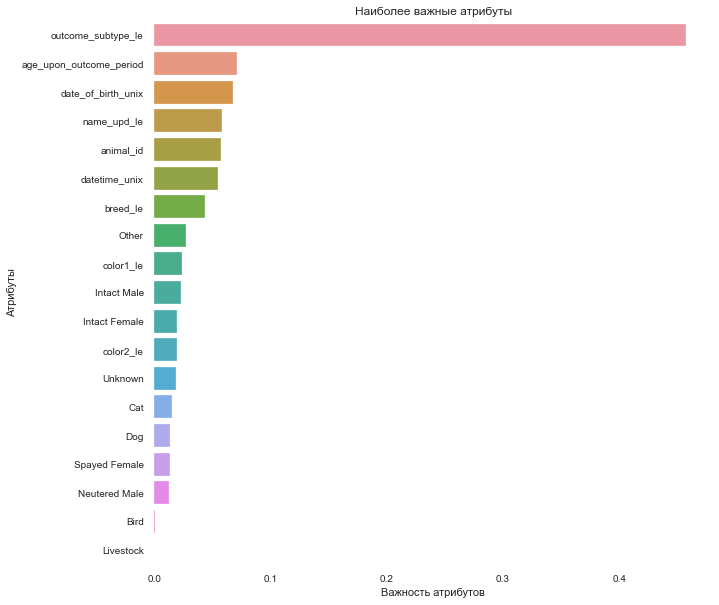

In [181]:
headers = list(X_train.columns.values)

# вклад каждого из регрессоров в целевое значение, 
feature_imp = pd.Series(model.feature_importances_, index=headers).sort_values(ascending=False)

f, ax = plt.subplots(figsize=(10, 10))
sns.barplot(x=feature_imp, y=feature_imp.index)

plt.xlabel('Важность атрибутов')
plt.ylabel('Атрибуты')
plt.title("Наиболее важные атрибуты")
plt.show()

In [182]:
from sklearn.metrics import classification_report


model_pred = model.predict(X_test)
print(classification_report(y_test, model_pred))
model.score(X_test, y_test)

                 precision    recall  f1-score   support

       Adoption       0.84      0.90      0.87     10071
           Died       0.92      0.75      0.83       215
       Disposal       0.68      0.60      0.64        83
     Euthanasia       0.98      0.96      0.97      1768
        Missing       0.00      0.00      0.00        11
       Relocate       0.00      0.00      0.00         6
Return to Owner       0.72      0.63      0.67      4325
      Rto-Adopt       0.00      0.00      0.00        41
       Transfer       1.00      1.00      1.00      6952

       accuracy                           0.88     23472
      macro avg       0.57      0.54      0.55     23472
   weighted avg       0.87      0.88      0.88     23472



0.8793456032719836

Хороший результат win-)